# Decision Trees on Titanic (Classification)

Στόχοι του notebook:

- Να υλοποιήσουμε ένα δέντρο αποφάσεων για κατηγοριοποίηση (επιβίωση στο Titanic).
- Να συγκρίνουμε Gini vs Entropy (Information Gain).
- Να δούμε underfitting / overfitting μεταβάλλοντας το `max_depth`.
- Να κάνουμε απλό inference σε έναν νέο επιβάτη.

Αναμενόμενο αρχείο δεδομένων:

- `data/titanic_train.csv` (από το Kaggle Titanic competition).


In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

ROOT = Path("..").resolve()
DATA_PATH = ROOT / "data" / "titanic_train.csv"

DATA_PATH


PosixPath('/home/ikons/adv-ai/data/titanic_train.csv')

In [11]:
df = pd.read_csv(DATA_PATH)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Επιλογή χαρακτηριστικών & προεπεξεργασία

- Χρησιμοποιούμε ένα υποσύνολο από τα διαθέσιμα χαρακτηριστικά.
- Κάνουμε απλή αντιμετώπιση ελλιπών τιμών (median / mode).
- Χρησιμοποιούμε `OneHotEncoder` για κατηγορικά χαρακτηριστικά.


In [12]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target = "Survived"

df = df[features + [target]]

df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

X = df[features]
y = df[target]

cat_cols = ["Sex", "Embarked"]
num_cols = [c for c in features if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

X_train.shape, X_val.shape


((712, 7), (179, 7))

## Εκπαίδευση δέντρου με διαφορετικά κριτήρια (Gini / Entropy)


In [13]:
def train_and_eval(criterion, max_depth=None):
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        random_state=0,
    )
    pipe = Pipeline([("preprocess", preprocessor), ("model", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    print(f"=== criterion={criterion}, max_depth={max_depth} ===")
    print(classification_report(y_val, y_pred, digits=3))
    return pipe

pipe_gini = train_and_eval("gini", max_depth=4)
pipe_entropy = train_and_eval("entropy", max_depth=4)


=== criterion=gini, max_depth=4 ===
              precision    recall  f1-score   support

           0      0.818     0.900     0.857       110
           1      0.810     0.681     0.740        69

    accuracy                          0.816       179
   macro avg      0.814     0.791     0.799       179
weighted avg      0.815     0.816     0.812       179

=== criterion=entropy, max_depth=4 ===
              precision    recall  f1-score   support

           0      0.818     0.900     0.857       110
           1      0.810     0.681     0.740        69

    accuracy                          0.816       179
   macro avg      0.814     0.791     0.799       179
weighted avg      0.815     0.816     0.812       179



## 📊 Ερμηνεία Μετρικών Απόδοσης (Classification Metrics)

Κατά την αξιολόγηση του μοντέλου ταξινόμησης (π.χ. Decision Tree για το Titanic),  
οι πιο σημαντικές μετρικές είναι οι εξής:

---

### 🎯 Precision (Ακρίβεια)
\[
\text{Precision} = \frac{TP}{TP + FP}
\]

> Από όλες τις περιπτώσεις που το μοντέλο **προέβλεψε "επέζησε"**,  
> πόσες ήταν πράγματι επιζώντες.

---

### 🔎 Recall (Ανάκληση)
\[
\text{Recall} = \frac{TP}{TP + FN}
\]

> Από όλους τους **πραγματικούς επιζώντες**,  
> πόσους εντόπισε σωστά το μοντέλο.

---

### ⚖️ F1-score
\[
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\]

> Ο αρμονικός μέσος του Precision και του Recall.  
> Ισορροπεί την επίδοση μεταξύ ψευδών θετικών και ψευδών αρνητικών.

---

### ✅ Accuracy (Ακρίβεια συνολικά)
\[
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
\]

> Το ποσοστό των συνολικών προβλέψεων που ήταν σωστές.

---

### 📦 Support
> Ο αριθμός των δειγμάτων αυτής της κατηγορίας στο validation set.

---

### 🧮 Παράδειγμα Ερμηνείας

Αν για την κατηγορία **"1 = Επέζησε"** το report δείχνει:

| Μετρική | Τιμή |
|----------|------|
| Precision | 0.82 |
| Recall | 0.70 |
| F1-score | 0.76 |

Σημαίνει ότι:
- Από όσους προέβλεψε ως "επέζησαν", **το 82% ήταν πράγματι επιζώντες**.  
- Εντόπισε **το 70% των πραγματικών επιζώντων**.  
- Η συνολική ισορροπημένη επίδοση είναι **0.76 (F1-score)**.

---

### 🧭 Ερμηνεία συνολικά
- Υψηλό **precision** αλλά χαμηλό **recall** → συντηρητικό μοντέλο (προβλέπει λίγους επιζώντες αλλά σωστά).  
- Υψηλό **recall** αλλά χαμηλό **precision** → ριψοκίνδυνο μοντέλο (προβλέπει πολλούς επιζώντες, με αρκετά λάθη).  
- Υψηλό **F1-score** → καλή ισορροπία μεταξύ των δύο.  
- Υψηλό **accuracy** → γενικά καλή συνολική επίδοση στα δεδομένα.

---

### 📘 Επεξήγηση Συμβόλων
| Σύμβολο | Ερμηνεία |
|----------|-----------|
| **TP** | True Positives (σωστά θετικά) |
| **TN** | True Negatives (σωστά αρνητικά) |
| **FP** | False Positives (ψευδώς θετικά) |
| **FN** | False Negatives (ψευδώς αρνητικά) |


## Underfitting / Overfitting: επίδραση του `max_depth`


In [14]:
depths = [2, 3, 4, 6, 8, None]
rows = []

for d in depths:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=0)
    pipe = Pipeline([("preprocess", preprocessor), ("model", clf)])
    pipe.fit(X_train, y_train)
    acc_train = pipe.score(X_train, y_train)
    acc_val = pipe.score(X_val, y_val)
    rows.append({"max_depth": d if d is not None else "None",
                 "train_acc": acc_train,
                 "val_acc": acc_val})

results_df = pd.DataFrame(rows)
results_df


,max_depth,train_acc,val_acc
0,2,0.790730,0.770950
1,3,0.823034,0.810056
2,4,0.841292,0.815642
3,6,0.849719,0.782123
4,8,0.890449,0.759777
5,None,0.983146,0.698324


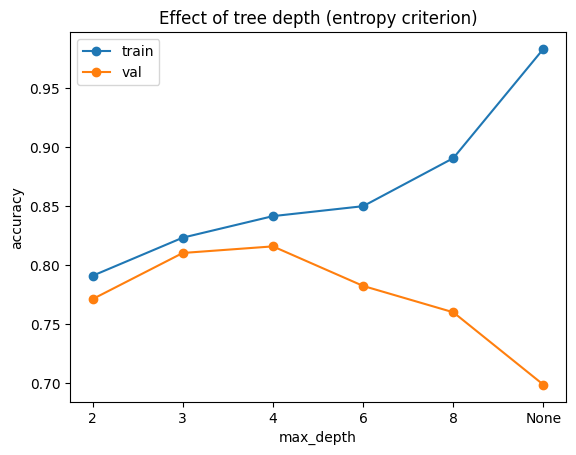

In [15]:
plt.figure()
x = results_df["max_depth"].astype(str)
plt.plot(x, results_df["train_acc"], marker="o", label="train")
plt.plot(x, results_df["val_acc"], marker="o", label="val")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Effect of tree depth (entropy criterion)")
plt.legend()
plt.show()


## 📊 Ερμηνεία Μετρικών Απόδοσης (Classification Metrics)

Κατά την αξιολόγηση του μοντέλου ταξινόμησης (π.χ. Decision Tree για το Titanic),  
οι πιο σημαντικές μετρικές είναι οι εξής:

---

### 🎯 Precision (Ακρίβεια)

$\text{Precision} = \frac{TP}{TP + FP}$
> Από όλες τις περιπτώσεις που το μοντέλο **προέβλεψε "επέζησε"**,  
> πόσες ήταν πράγματι επιζώντες.

---

### 🔎 Recall (Ανάκληση)

$\text{Recall} = \frac{TP}{TP + FN}$
> Από όλους τους **πραγματικούς επιζώντες**,  
> πόσους εντόπισε σωστά το μοντέλο.

---

### ⚖️ F1-score

$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

> Ο αρμονικός μέσος του Precision και του Recall.  
> Ισορροπεί την επίδοση μεταξύ ψευδών θετικών και ψευδών αρνητικών.

---

### ✅ Accuracy (Ακρίβεια συνολικά)
$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

> Το ποσοστό των συνολικών προβλέψεων που ήταν σωστές.

---

### 📦 Support
> Ο αριθμός των δειγμάτων αυτής της κατηγορίας στο validation set.

---

### 🧮 Παράδειγμα Ερμηνείας

Αν για την κατηγορία **"1 = Επέζησε"** το report δείχνει:

| Μετρική | Τιμή |
|----------|------|
| Precision | 0.82 |
| Recall | 0.70 |
| F1-score | 0.76 |

Σημαίνει ότι:
- Από όσους προέβλεψε ως "επέζησαν", **το 82% ήταν πράγματι επιζώντες**.  
- Εντόπισε **το 70% των πραγματικών επιζώντων**.  
- Η συνολική ισορροπημένη επίδοση είναι **0.76 (F1-score)**.

---

### 🧭 Ερμηνεία συνολικά
- Υψηλό **precision** αλλά χαμηλό **recall** → συντηρητικό μοντέλο (προβλέπει λίγους επιζώντες αλλά σωστά).  
- Υψηλό **recall** αλλά χαμηλό **precision** → ριψοκίνδυνο μοντέλο (προβλέπει πολλούς επιζώντες, με αρκετά λάθη).  
- Υψηλό **F1-score** → καλή ισορροπία μεταξύ των δύο.  
- Υψηλό **accuracy** → γενικά καλή συνολική επίδοση στα δεδομένα.

---

### 📘 Επεξήγηση Συμβόλων

| Σύμβολο | Ονομασία (EN/GR) | Ερμηνεία |
|----------|------------------|-----------|
| **TP** | True Positives (Σωστά Θετικά) | Περιπτώσεις όπου το μοντέλο **προέβλεψε “Επέζησε”** και πράγματι ο επιβάτης **επέζησε**. |
| **TN** | True Negatives (Σωστά Αρνητικά) | Περιπτώσεις όπου το μοντέλο **προέβλεψε “Δεν επέζησε”** και πράγματι ο επιβάτης **δεν επέζησε**. |
| **FP** | False Positives (Ψευδώς Θετικά) | Περιπτώσεις όπου το μοντέλο **προέβλεψε “Επέζησε”**, αλλά στην πραγματικότητα ο επιβάτης **δεν επέζησε**. |
| **FN** | False Negatives (Ψευδώς Αρνητικά) | Περιπτώσεις όπου το μοντέλο **προέβλεψε “Δεν επέζησε”**, αλλά ο επιβάτης **επέζησε** στην πραγματικότητα. |

---

> 💡 Με απλά λόγια:
> - **FP** → υπερεκτίμηση (λάθος “σωτηρία”)  
> - **FN** → υποεκτίμηση (λάθος “θάνατος”)  
> - **TP/TN** → σωστές προβλέψεις  
>  
> Το **ιδανικό μοντέλο** έχει FP = FN = 0 και πολλά TP + TN.


## Οπτικοποίηση δέντρου (μικρό βάθος)

Χρησιμοποιούμε το μοντέλο με `criterion="entropy"` και `max_depth=4` για να
δούμε τη δομή του δέντρου.


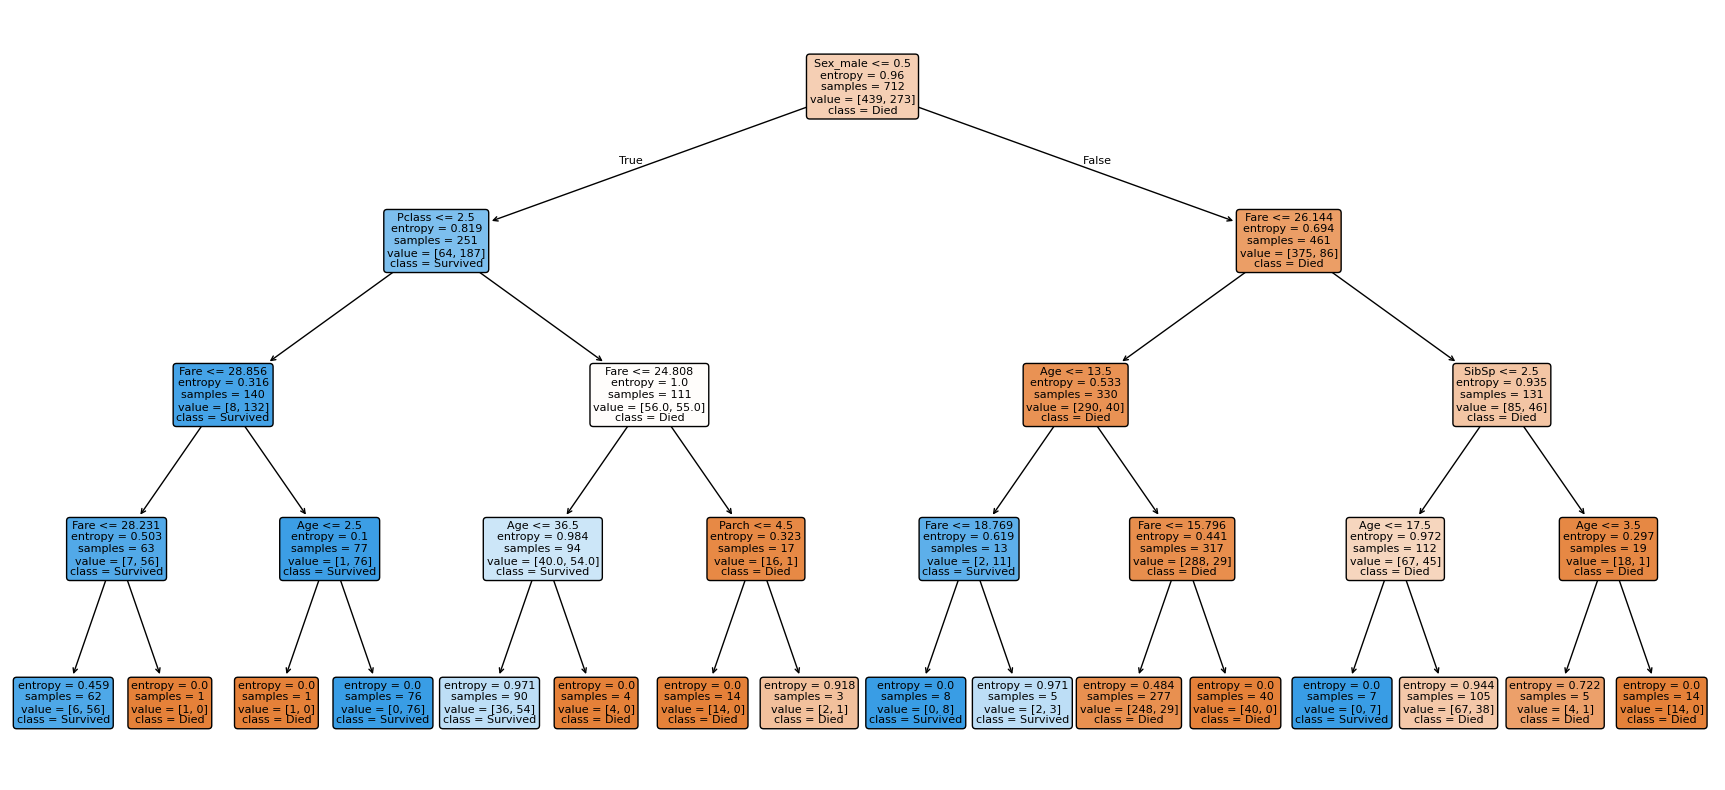

In [16]:
tree_clf = pipe_entropy.named_steps["model"]
ohe = pipe_entropy.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = cat_feature_names + num_cols

plt.figure(figsize=(22, 10))
plot_tree(
    tree_clf,
    feature_names=feature_names,
    class_names=["Died", "Survived"],
    filled=True,
    rounded=True,
    fontsize=8,
)
plt.show()


## 🌳 Σημασία χαρακτηριστικών (Feature Importances)

Κάθε δέντρο αποφάσεων μπορεί να μας δείξει **πόσο σημαντικό** θεωρεί κάθε χαρακτηριστικό
στη διαδικασία λήψης αποφάσεων.

Η σημασία (`feature_importances_`) υπολογίζεται ως το **ποσοστό της συνολικής μείωσης αβεβαιότητας (impurity reduction)**
που οφείλεται σε κάθε χαρακτηριστικό.

🔹 **Δηλαδή:**
- Κάθε φορά που το δέντρο χωρίζει έναν κόμβο (split) με βάση ένα χαρακτηριστικό,
  μειώνει την αβεβαιότητα (π.χ. Gini ή Entropy) των κόμβων.
- Όσο μεγαλύτερη είναι αυτή η μείωση και όσο συχνότερα χρησιμοποιείται το χαρακτηριστικό,
  τόσο μεγαλύτερη η σημασία του.
- Όλες οι σημασίες κανονικοποιούνται ώστε να αθροίζονται στο **1.0**.

🔹 **Παράδειγμα ερμηνείας:**
Αν `Sex_female` έχει σημασία 0.45 και `Pclass` 0.25, τότε το φύλο συνέβαλε περίπου **διπλάσια**
στην πρόβλεψη επιβίωσης σε σχέση με την ταξική θέση.

Θα εμφανίσουμε τώρα τις σημασίες και ένα γράφημα κατάταξης.


=== Σημασία χαρακτηριστικών (Feature Importances) ===
Sex_male            : 0.489
Age                 : 0.162
Fare                : 0.161
Pclass              : 0.156
SibSp               : 0.025
Parch               : 0.008
Embarked_S          : 0.000
Embarked_Q          : 0.000
Embarked_C          : 0.000
Sex_female          : 0.000


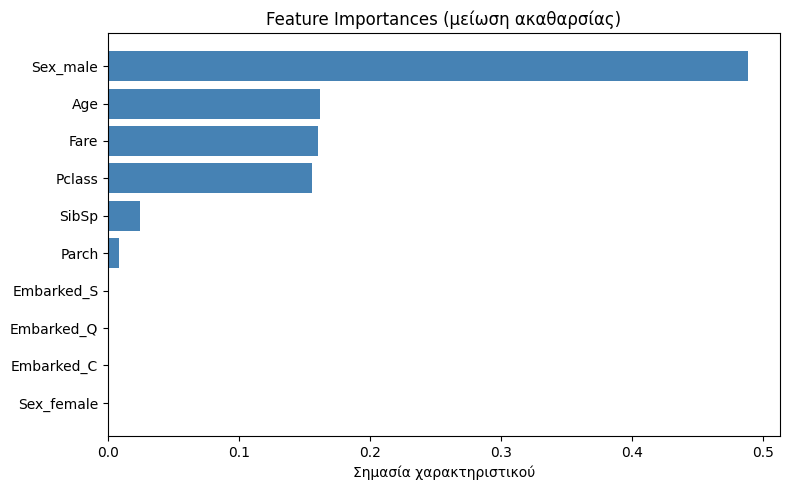

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Παίρνουμε το εκπαιδευμένο pipeline (π.χ. pipe_entropy ή pipe_gini)
# Εδώ υποθέτουμε ότι έχεις ήδη τρέξει το pipe_entropy στο notebook
model = pipe_entropy.named_steps["model"]
ohe = pipe_entropy.named_steps["preprocess"].named_transformers_["cat"]

# Λίστα με τα ονόματα όλων των χαρακτηριστικών (μετά το OneHotEncoding)
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = cat_feature_names + num_cols

# Παίρνουμε τις σημασίες από το decision tree
importances = model.feature_importances_

# Ταξινομούμε φθίνουσα
indices = np.argsort(importances)[::-1]
sorted_features = [(feature_names[i], importances[i]) for i in indices]

# Εμφάνιση σε πίνακα
print("=== Σημασία χαρακτηριστικών (Feature Importances) ===")
for name, imp in sorted_features:
    print(f"{name:20s}: {imp:.3f}")

# Γράφημα
plt.figure(figsize=(8,5))
plt.barh([feature_names[i] for i in indices][::-1],
         [importances[i] for i in indices][::-1],
         color="steelblue")
plt.xlabel("Σημασία χαρακτηριστικού")
plt.title("Feature Importances (μείωση ακαθαρσίας)")
plt.tight_layout()
plt.show()


## Inference για έναν νέο επιβάτη

Ορίζουμε έναν υποθετικό επιβάτη και ζητάμε από το μοντέλο να προβλέψει
αν θα επιβίωνε ή όχι.


In [18]:
example = {
    "Pclass": 3,
    "Sex": "female",
    "Age": 22.0,
    "SibSp": 1,
    "Parch": 0,
    "Fare": 7.25,
    "Embarked": "S",
}

X_new = pd.DataFrame([example])
proba = pipe_entropy.predict_proba(X_new)[0]
pred = pipe_entropy.predict(X_new)[0]

print("Input:", example)
print("Predicted:", int(pred), "(0 = died, 1 = survived)")
print("Probabilities:", proba)


Input: {'Pclass': 3, 'Sex': 'female', 'Age': 22.0, 'SibSp': 1, 'Parch': 0, 'Fare': 7.25, 'Embarked': 'S'}
Predicted: 1 (0 = died, 1 = survived)
Probabilities: [0.4 0.6]
